In [2]:
%load_ext autoreload
%autoreload 2

import src.simulation.water_demands as wd
from pathlib import Path
import warnings 
warnings.filterwarnings("ignore")
Path.cwd()

2024-07-08 02:27:59.983 | INFO     | src.const:get_project_root:20 - PROJECT_ROOT set to /Users/adamzh0u/315_RL/cege_test


PosixPath('/Users/adamzh0u/315_RL/cege_test')

## test

In [12]:
water_demand[100:].min(), water_demand[100:].max()

(-0.6194127159474498, 0.4043631408564916)

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
n_points = 10000
p, d, q = 5, 2, 5
model = ARIMA(np.random.randn(n_points), order=(p, d, q))
model_fit = model.fit()
water_demand = model_fit.predict(start=0, end=n_points-1)

In [3]:
model_fit.summary()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10000
Model:                 ARIMA(5, 2, 5)   Log Likelihood              -14232.106
Date:                Sun, 07 Jul 2024   AIC                          28486.213
Time:                        02:07:49   BIC                          28565.524
Sample:                             0   HQIC                         28513.059
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.6938      0.011   -247.323      0.000      -2.715      -2.672
ar.L2         -2.6526      0.030    -89.198      0.000      -2.711      -2.594
ar.L3         -0.9266      0.038    -24.159      0.0

## genertate data 

- seed > 100  leak_increase_range=(5, 10)
- seed > 200 leak_increase_range=(4,8)

In [14]:
# generate 10 independent water demands data 
# for seed in range(50):
for seed in range(242,247):
    num_leaks = 12
    df = wd.simulation(seed, num_leaks)
    wd.save(df, seed, num_leaks)

Data saved successfully Data_water_demand_with_leaks_242_12.txt
Data saved successfully Data_water_demand_with_leaks_243_12.txt
Data saved successfully Data_water_demand_with_leaks_244_12.txt
Data saved successfully Data_water_demand_with_leaks_245_12.txt
Data saved successfully Data_water_demand_with_leaks_246_12.txt


Text(0.5, 1.0, 'Leakages Increasing Range from 4 to 8')

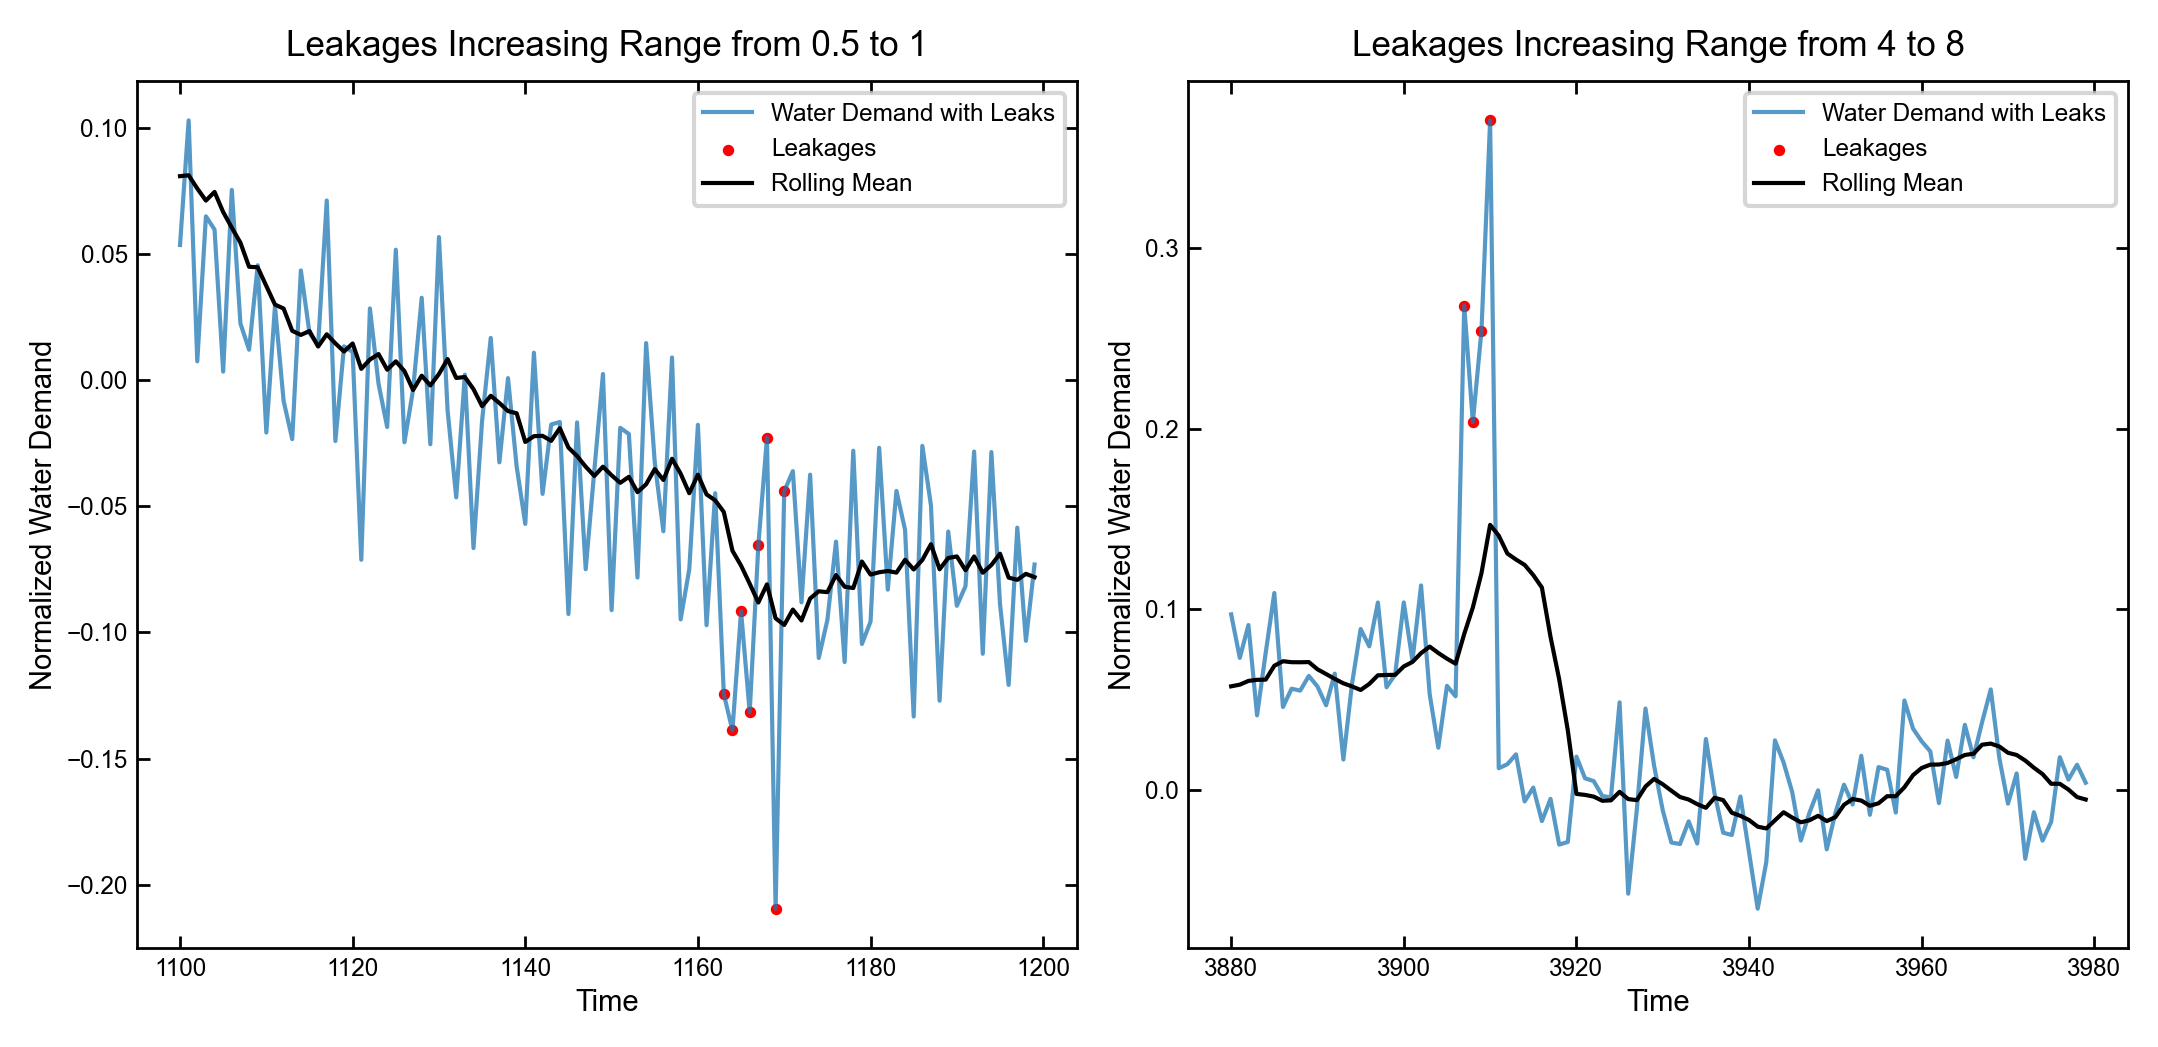

In [42]:
## window size
dft =  wd.load(43, 12) 
ws = 10
dft['rolling_mean'] = dft['WaterDemandWithLeaks'].rolling(window=ws).mean()

dft2 = wd.load(243, 12)
dft2['rolling_mean'] = dft2['WaterDemandWithLeaks'].rolling(window=ws).mean()

import src.utils.plot_utils as pu
import matplotlib.pyplot as plt
pu.setup_mpl(as_default=0)

dfp = dft[1100:1200]
dfp2 = dft2[3880:3980]

fig,ax = plt.subplots(1,2, figsize=(3.60236*2, 3.5),dpi=300)

ax[0].plot(dfp.index, dfp['WaterDemandWithLeaks'],
            label='Water Demand with Leaks', alpha=0.75)
ax[0].scatter(dfp[dfp['LeakageLabel'] == 1].index, dfp[dfp['LeakageLabel']
            == 1]['WaterDemandWithLeaks'], color='red', label='Leakages',s=3)
ax[0].plot(dfp.index, dfp['rolling_mean'], label='Rolling Mean', color='black')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Normalized Water Demand')
ax[0].set_title('Leakages Increasing Range from 0.5 to 1')

ax[1].plot(dfp2.index, dfp2['WaterDemandWithLeaks'],
            label='Water Demand with Leaks', alpha=0.75)
ax[1].scatter(dfp2[dfp2['LeakageLabel'] == 1].index, dfp2[dfp2['LeakageLabel']
            == 1]['WaterDemandWithLeaks'], color='red', label='Leakages',s=3)   
ax[1].plot(dfp2.index, dfp2['rolling_mean'], label='Rolling Mean', color='black')
ax[1].legend()

ax[1].set_xlabel('Time')
ax[1].set_ylabel('Normalized Water Demand')
ax[1].set_title('Leakages Increasing Range from 4 to 8')

## award

In [16]:
dft2 = wd.load(243, 12)

1.231369

In [18]:
import pandas as pd
import numpy as np
dft2['Timestamp'] = pd.to_datetime(dft2['Timestamp'])
dft2['hour'] = dft2['Timestamp'].dt.hour

traffic_flow = np.array([20,15,10,10,10,20,
                        30,50,70,100, 90,80, 
                        60,55,50,50,60,90,
                        95,70,60,40,30,20
                        ])
dft2['TrafficFlow'] = traffic_flow[dft2['hour'].values]

# downtime_cost : rolling following 1 hour
dft2['a_downtime_award'] = -dft2['WaterDemandWithLeaks'].rolling(window=4).sum().shift(-3)
dft2['a_congestion_award'] = -dft2['TrafficFlow']*0.15
dft2['a_environmental_award'] = -np.log1p(dft2['LeakageLabel'].rolling(window=12).sum())
dft2['a_fix_award'] =  np.log1p(dft2['LeakageLabel'].rolling(window=12).sum().shift(-11).sum())
dft2['a_total_award'] = 8 + dft2['a_downtime_award'] + dft2['a_congestion_award'] + dft2['a_environmental_award'] + dft2['a_fix_award']

dft2['n_leakage_award'] = -dft2['WaterDemandWithLeaks'].rolling(window=12).sum().shift(-11)
dft2['n_environmental_award'] = -np.log1p(dft2['LeakageLabel'].rolling(window=30*24*4).sum())
dft2['n_total_award'] = dft2['n_leakage_award'] + dft2['n_environmental_award'] - 8

# mean fill na
dft2.fillna(dft2.mean(), inplace=True)

array([[<Axes: title={'center': 'n_total_award'}>]], dtype=object)

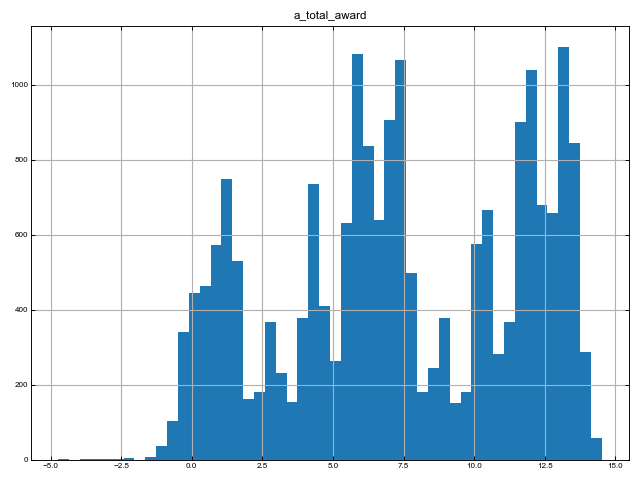

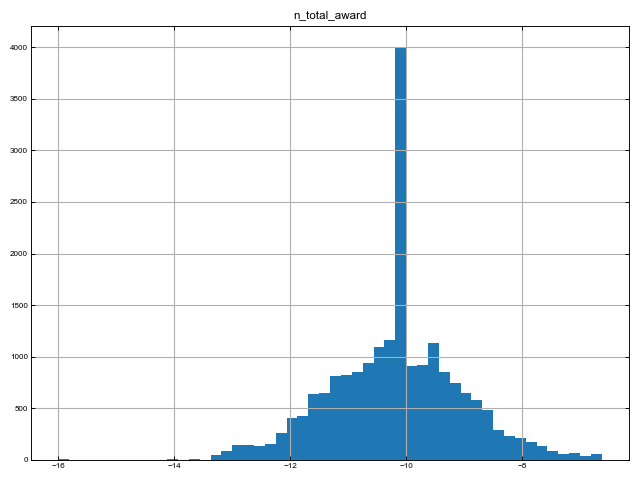

In [135]:
dft2.hist('a_total_award',bins=50)
dft2.hist('n_total_award',bins=50)

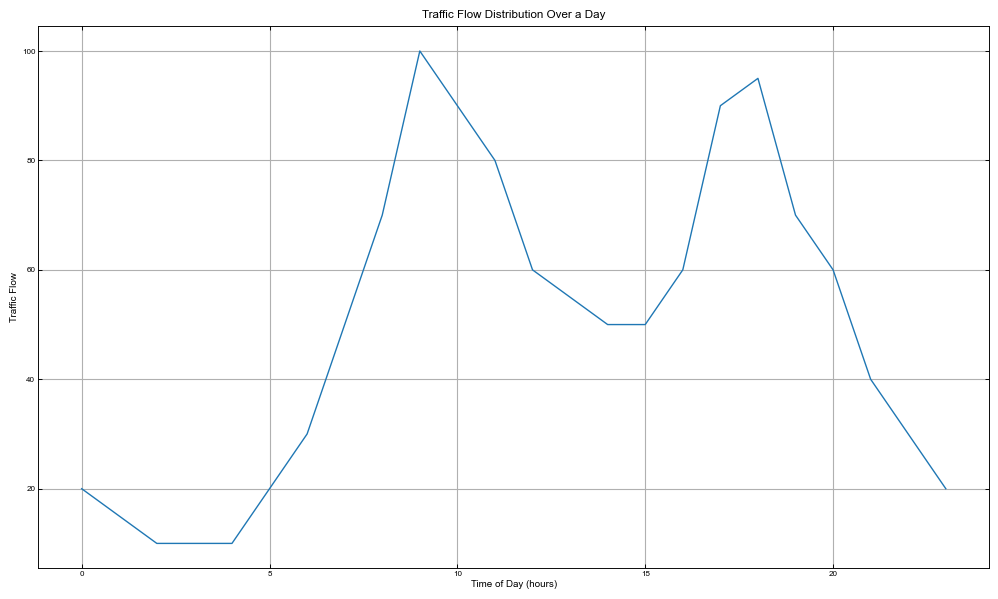

In [66]:
import numpy as np
import matplotlib.pyplot as plt

time = np.arange(0, 24, 1)


# 可视化交通流量随时间的分布
plt.figure(figsize=(10, 6))
plt.plot(time, traffic_flow, label='Traffic Flow',)
plt.xlabel('Time of Day (hours)')
plt.ylabel('Traffic Flow')
plt.title('Traffic Flow Distribution Over a Day')
plt.grid(True)

In [45]:
dft2

,Timestamp,WaterDemandWithLeaks,LeakageLabel
0,2024-01-01 00:00:00,0.287349,0.0
1,2024-01-01 00:15:00,0.304498,0.0
2,2024-01-01 00:30:00,0.292061,0.0
3,2024-01-01 00:45:00,0.312455,0.0
4,2024-01-01 01:00:00,0.322355,0.0
...,...,...,...
20395,2024-07-31 10:45:00,0.050964,0.0
20396,2024-07-31 11:00:00,0.059955,0.0
20397,2024-07-31 11:15:00,0.100155,0.0
20398,2024-07-31 11:30:00,0.109897,0.0


## test EnvComplexR

In [25]:
import src.env.env_basic as env_basic
import src.simulation.water_demands as wd

dft = wd.load(243, 12)

env = env_basic.EnvComplexR(dft)
env.reset()


(array([-0.01928942, -0.01883427,  0.00210519, -0.00350556,  0.00296355,
         0.0061122 , -0.03088086, -0.00671616,  0.00673889,  0.03825076]),
 {'step': 384})

In [26]:
for i in range(10000):
    r = env.step(0)[1]
    if r ==0.1:
        pass
    else:
        print(r)
        break

-9.18
